[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/01-Training.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, concatenate, LeakyReLU, Reshape, Lambda, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Data loading and preparation

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

X = np.concatenate([x_train,x_test])
y = np.concatenate([y_train, y_test])

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
X = X.astype('float32')

X = X / 255.0

In [ ]:
input_shape = X.shape[1:]
number_layers = 128
latent_dim = 128

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [ ]:
def show_performance(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# CNN for image classification

In [ ]:
def define_CNN_model():

	model = Sequential()
	model.add(Conv2D(number_layers, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Conv2D(number_layers*2, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Conv2D(number_layers*4, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Flatten())
	model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
 
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)

	model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model = define_CNN_model()
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
history = model.fit(x_train, y_train, epochs=20, shuffle=True, validation_data=(x_val, y_val), batch_size=32, callbacks=[es], verbose=1)

Epoch 1/20
1500/1500 [==============================] - 23s 8ms/step - loss: 1.4385 - accuracy: 0.5056 - val_loss: 2.2301 - val_accuracy: 0.3853
Epoch 2/20
1500/1500 [==============================] - 11s 8ms/step - loss: 1.0194 - accuracy: 0.6442 - val_loss: 1.0167 - val_accuracy: 0.6532
Epoch 3/20
1500/1500 [==============================] - 11s 8ms/step - loss: 0.8413 - accuracy: 0.7090 - val_loss: 1.3780 - val_accuracy: 0.5860
Epoch 4/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.7275 - accuracy: 0.7475 - val_loss: 1.0314 - val_accuracy: 0.6598
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6283 - accuracy: 0.7824 - val_loss: 0.7908 - val_accuracy: 0.7390
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.5442 - accuracy: 0.8100 - val_loss: 0.8888 - val_accuracy: 0.7173
Epoch 7/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4718 - accuracy: 0.8351 - val_loss: 0.8490 - val_ac

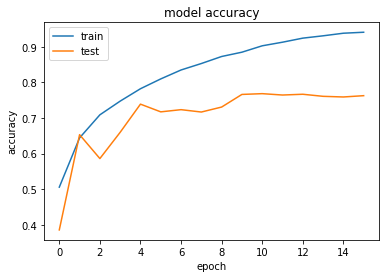

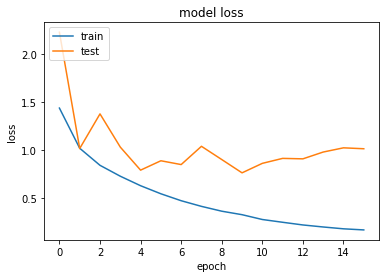

In [ ]:
show_performance(history)

In [ ]:
y_pred = model.predict(x_test).argmax(axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       583
           1       0.96      0.67      0.79       581
           2       0.76      0.60      0.67       611
           3       0.62      0.58      0.60       673
           4       0.71      0.78      0.74       606
           5       0.59      0.81      0.68       616
           6       0.82      0.83      0.82       563
           7       0.87      0.77      0.81       628
           8       0.79      0.89      0.84       566
           9       0.71      0.91      0.80       573

    accuracy                           0.75      6000
   macro avg       0.77      0.75      0.75      6000
weighted avg       0.77      0.75      0.75      6000



# Autoencoder 1

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same', name='embedding')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 256)      1024  

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'),es])

Epoch 1/100
375/375 [==============================] - 43s 99ms/step - loss: 0.0213 - val_loss: 0.0357
Epoch 2/100
375/375 [==============================] - 33s 89ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 3/100
375/375 [==============================] - 34s 90ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 4/100
375/375 [==============================] - 34s 91ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 5/100
375/375 [==============================] - 34s 91ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 6/100
375/375 [==============================] - 34s 92ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 7/100
375/375 [==============================] - 34s 92ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 8/100
375/375 [==============================] - 34s 92ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 9/100
375/375 [==============================] - 35s 92ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/100
375/375 [==============================] - 35s 93ms/step - l

In [ ]:
last_layer = autoencoder.get_layer('embedding').output

x = Flatten()(last_layer)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

autoencoder.trainable = False

fine_tune_model = Model(inputs=autoencoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 256)      1024

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history = fine_tune_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), batch_size=32, callbacks=[es],verbose=1)

Epoch 1/100
1500/1500 [==============================] - 12s 7ms/step - loss: 1.2756 - accuracy: 0.5448 - val_loss: 1.0881 - val_accuracy: 0.6167
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.9460 - accuracy: 0.6641 - val_loss: 1.0186 - val_accuracy: 0.6452
Epoch 3/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.7683 - accuracy: 0.7292 - val_loss: 1.0170 - val_accuracy: 0.6593
Epoch 4/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.6219 - accuracy: 0.7807 - val_loss: 1.1060 - val_accuracy: 0.6482
Epoch 5/100
1500/1500 [==============================] - 10s 6ms/step - loss: 0.4874 - accuracy: 0.8255 - val_loss: 1.1929 - val_accuracy: 0.6487
Epoch 6/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3743 - accuracy: 0.8650 - val_loss: 1.3307 - val_accuracy: 0.6535
Epoch 7/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3294 - accuracy: 0.8857 - val_loss: 1.4027 - 

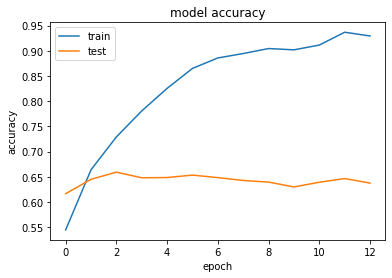

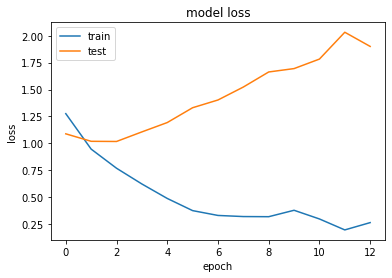

In [ ]:
show_performance(history)

# Autoencoder 2

* Linear
* (4,4)

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'),es])

Epoch 1/100
375/375 [==============================] - 98s 245ms/step - loss: 0.6360 - val_loss: 0.6535
Epoch 2/100
375/375 [==============================] - 94s 250ms/step - loss: 0.5941 - val_loss: 0.5891
Epoch 3/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5830 - val_loss: 0.5893
Epoch 4/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5774 - val_loss: 0.5760
Epoch 5/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5733 - val_loss: 0.5723
Epoch 6/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5707 - val_loss: 0.5700
Epoch 7/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5683 - val_loss: 0.5683
Epoch 8/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5662 - val_loss: 0.5655
Epoch 9/100
375/375 [==============================] - 95s 253ms/step - loss: 0.5646 - val_loss: 0.5651
Epoch 10/100
375/375 [==============================] - 97s 258m

In [ ]:
encoder = Model(input_img, encoded)
last_layer = encoder.output

x = Flatten()(last_layer)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

encoder.trainable = False

fine_tune_model = Model(inputs=encoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32, verbose=1)

Epoch 1/20
1500/1500 [==============================] - 21s 13ms/step - loss: 1.3895 - accuracy: 0.5025 - val_loss: 1.2059 - val_accuracy: 0.5788
Epoch 2/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.9627 - accuracy: 0.6584 - val_loss: 1.1364 - val_accuracy: 0.5950
Epoch 3/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.6865 - accuracy: 0.7564 - val_loss: 1.2112 - val_accuracy: 0.6005
Epoch 4/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4683 - accuracy: 0.8341 - val_loss: 1.3595 - val_accuracy: 0.5962
Epoch 5/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3202 - accuracy: 0.8866 - val_loss: 1.5373 - val_accuracy: 0.6050
Epoch 6/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2241 - accuracy: 0.9213 - val_loss: 1.7783 - val_accuracy: 0.5877
Epoch 7/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.1788 - accuracy: 0.9369 - val_loss: 1.9062 -

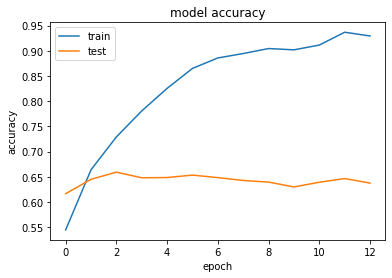

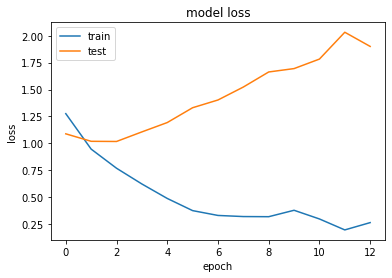

In [ ]:
show_performance(history)

# Autoencoder with two outputs (Construction loss + Classification task)

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same', name='decoded')(x)

reg_dense = Flatten()(encoded)
reg_dense = Dense(64, activation='relu')(reg_dense)
reg_dense = Dense(16, activation='relu')(reg_dense) 
class_output = Dense(10, activation='softmax', name='class_output')(reg_dense)

autoencoder = Model(inputs=input_img, outputs=[decoded,class_output])

losses ={ 'decoded':keras.losses.MeanSquaredError(),
    'class_output':keras.losses.SparseCategoricalCrossentropy()}

autoencoder.compile(optimizer='adam', loss=losses, metrics="accuracy")

In [ ]:
es = EarlyStopping(monitor='val_class_output_accuracy', mode='max', verbose=1, patience=10)
autoencoder.fit(x=x_train, y={'decoded': x_train, 'class_output': y_train},
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(x_val, {'decoded': x_val, 'class_output': y_val}),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'),es])

In [ ]:
encoder = Model(input_img, encoded)
last_layer = encoder.output

x = Flatten()(last_layer)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

encoder.trainable = False

fine_tune_model = Model(inputs=encoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       6272      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       524544    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024

In [ ]:
fine_tune_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32, verbose=1)

In [ ]:
y_pred = fine_tune_model.predict(x_test).argmax(axis=1)

print(classification_report(y_test, y_pred))

# Variational Autoencoder

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tensorflow.shape(z_mean)[0]
        dim = tensorflow.shape(z_mean)[1]
        epsilon = tensorflow.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tensorflow.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tensorflow.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tensorflow.reduce_mean(
                tensorflow.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tensorflow.square(z_mean) - tensorflow.exp(z_log_var))
            kl_loss = tensorflow.reduce_mean(tensorflow.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
encoder_inputs = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), padding='same')(encoder_inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.2)(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling(name="embedding")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 128)  6272        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 128)  0           ['conv2d_3[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 32, 32, 128)  512        ['leaky_re_lu[0][0]']            
 rmalization)                                                                               

In [ ]:
# at this point the representation is (2, 2, number_layer*8)
latent_inputs = Input(shape=(latent_dim,))
x = Dense(256, input_dim=latent_dim)(latent_inputs)
x = Reshape((2, 2, 64))(x)

x = Conv2D(number_layers*8, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoder_outputs = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 1024)        1049600   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2, 2, 1024)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 1024)       0         
 )                                                               
                                                           

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
vae.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
313/313 [==============================] - 156s 471ms/step - loss: 97.2243 - reconstruction_loss: 59.8125 - kl_loss: 3.7775
Epoch 2/20
313/313 [==============================] - 145s 463ms/step - loss: 41.5787 - reconstruction_loss: 35.1219 - kl_loss: 5.1798
Epoch 3/20
313/313 [==============================] - 145s 462ms/step - loss: 38.1384 - reconstruction_loss: 31.8251 - kl_loss: 6.1315
Epoch 4/20
313/313 [==============================] - 145s 463ms/step - loss: 37.1521 - reconstruction_loss: 30.3987 - kl_loss: 6.6856
Epoch 5/20
313/313 [==============================] - 145s 463ms/step - loss: 37.0395 - reconstruction_loss: 30.1726 - kl_loss: 6.7876
Epoch 6/20
313/313 [==============================] - 145s 463ms/step - loss: 36.7158 - reconstruction_loss: 29.6838 - kl_loss: 6.9610
Epoch 7/20
313/313 [==============================] - 145s 463ms/step - loss: 36.3665 - reconstruction_loss: 28.8326 - kl_loss: 7.3207
Epoch 8/20
313/313 [==============================] - 1

In [ ]:
last_layer = vae.encoder.get_layer('embedding').output

In [ ]:
x = Flatten()(last_layer)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

vae.encoder.trainable = False

fine_tune_model = Model(inputs=vae.encoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=32, verbose=1)